In [1]:
import sys
print(sys.path)

['', 'C:\\Users\\ramse\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\python35.zip', 'C:\\Users\\ramse\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\DLLs', 'C:\\Users\\ramse\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib', 'C:\\Users\\ramse\\AppData\\Local\\conda\\conda\\envs\\tensorflow', 'C:\\Users\\ramse\\AppData\\Roaming\\Python\\Python35\\site-packages', 'C:\\Users\\ramse\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib\\site-packages', 'C:\\Users\\ramse\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\ramse\\.ipython']


In [2]:
import pycocotools
import tensorflow as tf; print(tf.__version__)

C:\Users\ramse\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


In [4]:
import os
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

Using TensorFlow backend.


In [6]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

In [7]:
# define root_dir as current working directory
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [40]:
import pandas as pd
import PIL
folder_path = 'B:\\Programming\\'

carvana = folder_path + 'CarvanaDataSet'
carvana_train_path = carvana + '\\train\\train'
carvana_masks_path = carvana + '\\train_masks\\train_masks'
carvana_test_path = carvana + '\\test\\test'
carvana_train_metadata_path = carvana + '\\train_masks.csv' # this is for the training images
carvana_metadata_path = carvana + '\\metadata.csv' #this is for the test images

train_csv = pd.read_csv(carvana_train_metadata_path)
image_ids = train_csv['img']

length = len(image_ids)
split_at = math.floor(length * .2)
print(split_at)

training_ids = image_ids[:split_at]
testing_ids = image_ids[split_at:]

1017


In [92]:
class CarDataset():
    
    def __init__(self, image_ids):
#         self.image_ids = image_ids
        self.image_info = []
        self.image_ids = image_ids
        for i in range(len(image_ids)):
#             bg_color, shapes = self.random_image(height, width)
            self.add_image("car", image_id=i, path=None)
    
    def add_image(self, source, image_id, path):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        self.image_info.append(image_info)
    
    def load_image(self, image_id):
        
        info = self.image_info[self.image_ids.index(image_id)]
        path_to_view = carvana_train_path + '\\' + image_id 
        img = cv2.imread(path_to_view)
        return img
    
    def load_mask(self, image_id):
        info = self.image_info[self.image_ids.index(image_id)]
        image_id = image_id[:-4]
        path_to_view = carvana_masks_path + '\\' + image_id + '_mask.gif'
#         img = cv2.imread(path_to_view)
        pil_image = PIL.Image.open(path_to_view).convert('RGB') 
        open_cv_image = np.array(pil_image) 
        # Convert RGB to BGR 
        open_cv_image = open_cv_image[:, :, ::-1].copy()
        return open_cv_image

00087a6bd4dc_01.jpg
[[[240 245 244]
  [240 245 244]
  [240 245 244]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[240 245 244]
  [240 245 244]
  [240 245 244]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[240 245 244]
  [240 245 244]
  [240 245 244]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 ...

 [[186 183 179]
  [186 183 179]
  [186 183 179]
  ...
  [179 180 176]
  [179 180 176]
  [179 180 176]]

 [[186 183 179]
  [186 183 179]
  [186 183 179]
  ...
  [179 180 176]
  [179 180 176]
  [179 180 176]]

 [[186 183 179]
  [186 183 179]
  [186 183 179]
  ...
  [179 180 176]
  [179 180 176]
  [179 180 176]]]


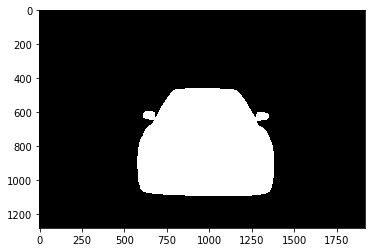

In [93]:
train = CarDataset(training_ids.tolist())
test = CarDataset(testing_ids.tolist())
print(train.image_ids[0])
print(train.load_image(train.image_ids[0]))
plt.imshow(train.load_mask(train.image_ids[0]))
plt.show()

In [94]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [95]:
model.train(train, test, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\ramse\Dropbox\SpotMe\Mask_RCNN-master\logs\shapes20190502T1148\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Ti

TypeError: list indices must be integers or slices, not numpy.str_